# Airbnb Capstone


Airbnb has significantly changed the nature of the short-term property rental market. Not only it has allowed homeowners to earn extra revenue by listing their properties but also provided travelers with great, easy, and convenient places to stay.  

Running Airbnb requires lots of investment, it seems simple on the surface, but it is very involved and complicated in today’s demanding hospitality market. With this in mind, I was still encouraged by the idea of making money from my home when I am not living in it. So in January 2022, I started renting out my two-bedroom condo near Santa Monica Pier. So far, the revenue does not look good and the occupancy rate is below average. Now that I have had a taste of being an Airbnb host for more than a year,  I decided to use data science to analyze the data of the city of Los Angeles which is one of the most active cities in Airbnb markets with more than 21,000 listings by end of 2022.  The goal of the project is to answer the questions below:

1. How are the listings distributed across the city of Los Angeles?
2. How do the prices vary with respect to the neighborhood, property type, and month/day?
3. How to use machine learning models to predict prices using features such as room type, the number of accommodations, the number of bedrooms, and so forth.



# 1. Data Wrangling

####  Import Packages


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gzip
import datetime as dt
import numpy as np

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split, cross_validate,KFold, GridSearchCV,cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

#### Load Listings Data Set
The datasets for this project was obtained from 
[Inside Airbnb](http://insideairbnb.com/get-the-data/). I am interested in listings and calendar data for Los Angeles city.


In [2]:
# only load the listing in "City of Los Angeles"

listings = pd.read_csv('listings.csv.gz', compression='gzip',error_bad_lines=False)
listings=listings[listings.neighbourhood_group_cleansed=="City of Los Angeles"]


C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print(listings.shape)
print(listings.info())

#Check for duplicate listing id
dup= listings.duplicated(subset="id")
print("Dupplicated ID listing",listings[dup==True].count().max())


(21003, 75)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21003 entries, 1 to 40435
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            21003 non-null  int64  
 1   listing_url                                   21003 non-null  object 
 2   scrape_id                                     21003 non-null  int64  
 3   last_scraped                                  21003 non-null  object 
 4   source                                        21003 non-null  object 
 5   name                                          21003 non-null  object 
 6   description                                   20669 non-null  object 
 7   neighborhood_overview                         12693 non-null  object 
 8   picture_url                                   21003 non-null  object 
 9   host_id                                       210

There are 21,003 listings in the area of Los Angeles and each listing has 75 columns. No duplicated ID listing was found. For the purpose of the problem solving, half of the columns seem like they are unuseful so they will be dropped in the next section. 


In [4]:
# drop un-useful colums to concentrate on important features
drop_list=['bathrooms','calendar_updated','name','id','host_id','listing_url','scrape_id','last_scraped','source',
           'description','neighborhood_overview','picture_url','host_url','host_name', 'host_since','host_location',
           'host_about','property_type','host_neighbourhood','neighbourhood_group_cleansed','neighbourhood',
           'host_response_time','host_response_rate', 'host_verifications','host_identity_verified',
           'host_thumbnail_url',   'host_picture_url', 'calendar_last_scraped','minimum_minimum_nights','maximum_minimum_nights',
           'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
           'host_has_profile_pic', 'first_review','last_review','host_listings_count','host_total_listings_count',
           'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
           'calculated_host_listings_count_private_rooms',  'calculated_host_listings_count_shared_rooms',
           'reviews_per_month','number_of_reviews_ltm','number_of_reviews_l30d', 'minimum_nights',
           'maximum_nights', 'has_availability', 'availability_30','availability_60', 'availability_90', 'availability_365',
           'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 
           'review_scores_location','review_scores_value', 'license','instant_bookable','host_is_superhost']

listings=listings.drop(columns=drop_list,axis=1)
# shorten neighborhood name
listings=listings.rename(columns={"neighbourhood_cleansed":"neighborhood"})

In [5]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21003 entries, 1 to 40435
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_acceptance_rate  15941 non-null  object 
 1   neighborhood          21003 non-null  object 
 2   latitude              21003 non-null  float64
 3   longitude             21003 non-null  float64
 4   room_type             21003 non-null  object 
 5   accommodates          21003 non-null  int64  
 6   bathrooms_text        20981 non-null  object 
 7   bedrooms              18760 non-null  float64
 8   beds                  20550 non-null  float64
 9   amenities             21003 non-null  object 
 10  price                 21003 non-null  object 
 11  number_of_reviews     21003 non-null  int64  
 12  review_scores_rating  14280 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 2.2+ MB


#### Missing Data


In [6]:
#count number of missing data in all columns and sort them from high to low
missing=pd.concat([listings.isnull().sum(),100*listings.isnull().mean()],axis=1)
missing.columns=["count","%"]
print(missing.sort_values(by="count",ascending=False)[missing["count"]>0])

                      count          %
review_scores_rating   6723  32.009713
host_acceptance_rate   5062  24.101319
bedrooms               2243  10.679427
beds                    453   2.156835
bathrooms_text           22   0.104747


C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Will deal with missing data after exploring and understanding data in more details

#### Categorical Features

In [7]:
listings.select_dtypes("object").head(1).T


1
host_acceptance_rate                                                38%
neighborhood                                       Hollywood Hills West
room_type                                                  Private room
bathrooms_text                                            1 shared bath
amenities             ["TV with standard cable", "Hot water", "First...
price                                                            $46.00

In [8]:
listings['host_acceptance_rate']=listings['host_acceptance_rate'].str.replace('%',"")
listings['host_acceptance_rate']=listings['host_acceptance_rate'].astype("float")
listings.select_dtypes("object").head(1).T

1
neighborhood                                 Hollywood Hills West
room_type                                            Private room
bathrooms_text                                      1 shared bath
amenities       ["TV with standard cable", "Hot water", "First...
price                                                      $46.00

#### bathroom_text


In [9]:
# split bathroom_texst into bathroom quanitty and type
listings['bathroom_qty']=listings.bathrooms_text.str.split(" ",expand=True)[0]
listings['bathroom_type']=listings.bathrooms_text.str.split(" ",expand=True)[1]
# count of bathrom qty
listings.bathroom_qty.value_counts()

1            12641
2             3333
2.5           1747
1.5            855
3              806
3.5            377
4              272
4.5            230
8              133
5.5            130
5              120
6               82
6.5             47
7               42
0               38
11              27
Shared          20
8.5             14
7.5             14
Half-bath       12
9                9
10               8
9.5              6
Private          3
12               3
11.5             2
13               2
10.5             2
12.5             1
13.5             1
25               1
21               1
20               1
15               1
Name: bathroom_qty, dtype: int64

In [10]:
# replace string with number
listings.loc[listings.bathroom_qty=="Shared",'bathroom_qty']=0
listings.loc[listings.bathroom_qty=="Half-bath" ,'bathroom_qty']=0.5
listings.loc[listings.bathroom_qty=="Private",'bathroom_qty']=0.5


#listings.bathroom_qty=listings.bathroom_qty.str.replace("Shared",0).str.replce("Half-bath",0.5).str.replace("Private",0.5)
listings.bathroom_qty=listings.bathroom_qty.astype("float")
listings[listings.bathroom_qty.isnull()]
#listings.bathroom_qty.isnull().sum()


host_acceptance_rate     neighborhood   latitude   longitude  \
27                      NaN  Hollywood Hills  34.128010 -118.319190   
62                      NaN      Studio City  34.144610 -118.415800   
319                    50.0     Mid-Wilshire  34.066450 -118.352100   
385                    93.0      Silver Lake  34.089740 -118.270210   
646                     NaN     Mid-Wilshire  34.058620 -118.325050   
1064                    NaN         Van Nuys  34.177230 -118.456340   
11298                   NaN         Westwood  34.062640 -118.443320   
11860                   NaN         Westwood  34.060990 -118.444980   
16102                   NaN      Harbor City  33.806460 -118.306930   
16271                   NaN         Westwood  34.060060 -118.437030   
16564                  97.0        Hollywood  34.090542 -118.312508   
16566                   NaN        Koreatown  34.062040 -118.300910   
17050                  99.0           Venice  33.986950 -118.472480   
17343                  97.0      Studio City  34.139410 -118.381100   
17349                 100.0      Studio City  34.137300 -118.364020   
17601                   NaN         Westwood  34.067470 -118.425760   
17818                  98.0        Hollywood  34.104650 -118.334490   
17982                   NaN       West Adams  34.032780 -118.343080   
17984                   NaN  North Hollywood  34.166880 -118.378770   
19090                   NaN        Hollywood  34.093020 -118.313780   
21133                   NaN    Beverly Grove  34.066457 -118.365303   
21877                   NaN        Koreatown  34.059430 -118.294270   

             room_type  accommodates bathrooms_text  bedrooms  beds  \
27     Entire home/apt             2            NaN       1.0   1.0   
62        Private room             1            NaN       1.0   NaN   
319       Private room             2            NaN       1.0   1.0   
385    Entire home/apt             2            NaN       1.0   1.0   
646       Private room             2            NaN       1.0   1.0   
1064   Entire home/apt             6            NaN       NaN   NaN   
11298       Hotel room             6            NaN       2.0   4.0   
11860       Hotel room             6            NaN       2.0   4.0   
16102     Private room             2            NaN       NaN   NaN   
16271     Private room             1            NaN       1.0   1.0   
16564       Hotel room             2            NaN       NaN   NaN   
16566       Hotel room             4            NaN       NaN   NaN   
17050       Hotel room             4            NaN       NaN   NaN   
17343       Hotel room             5            NaN       NaN   NaN   
17349       Hotel room             8            NaN       NaN   NaN   
17601       Hotel room             0            NaN       NaN   NaN   
17818       Hotel room             0            NaN       NaN   NaN   
17982       Hotel room             0            NaN       NaN   NaN   
17984       Hotel room             0            NaN       NaN   NaN   
19090     Private room             1            NaN       1.0   1.0   
21133       Hotel room             0            NaN       NaN   NaN   
21877     Private room             1            NaN       1.0   1.0   

                                               amenities    price  \
27     ["Wifi", "Bed linens", "TV with standard cable...  $110.00   
62                           ["Long term stays allowed"]  $200.00   
319    ["Wifi", "Hot tub", "TV with standard cable", ...   $89.00   
385    ["Private entrance", "TV with standard cable",...   $95.00   
646    ["Wifi", "Hot tub", "TV with standard cable", ...  $115.00   
1064                         ["Long term stays allowed"]  $125.00   
11298  ["TV with standard cable", "Dishes and silverw...  $197.00   
11860  ["TV with standard cable", "Dishes and silverw...  $199.00   
16102  ["Long term stays allowed", "Hangers", "Essent...   $40.00   
16271  ["Wifi", "Long term stays allowed", "Dryer

bathroom_text has been splitted into bathroom qty and type columns and the text qty also corrected with numeric value

#### Numeric Features

In [11]:
listings.describe().transpose()

count        mean        std        min        25%  \
host_acceptance_rate  15941.0   86.584781  23.639111    0.00000   85.00000   
latitude              21003.0   34.081064   0.074501   33.70549   34.04202   
longitude             21003.0 -118.375972   0.093773 -118.66307 -118.45154   
accommodates          21003.0    3.823597   2.718514    0.00000    2.00000   
bedrooms              18760.0    1.777665   1.227769    1.00000    1.00000   
beds                  20550.0    2.113090   1.575692    1.00000    1.00000   
number_of_reviews     21003.0   29.731276  70.044362    0.00000    0.00000   
review_scores_rating  14280.0    4.692506   0.678336    0.00000    4.67000   
bathroom_qty          20981.0    1.679972   1.260748    0.00000    1.00000   

                            50%         75%         max  
host_acceptance_rate   98.00000  100.000000   100.00000  
latitude               34.08047   34.122420    34.32590  
longitude            -118.36742 -118.305905  -118.15579  
accommodates            3.00000    5.000000    16.00000  
bedrooms                1.00000    2.000000    24.00000  
beds                    2.00000    3.000000    32.00000  
number_of_reviews       3.00000   23.000000  1924.00000  
review_scores_rating    4.90000    5.000000     5.00000  
bathroom_qty            1.00000    2.000000    25.00000

#### Distrubution of numeric features

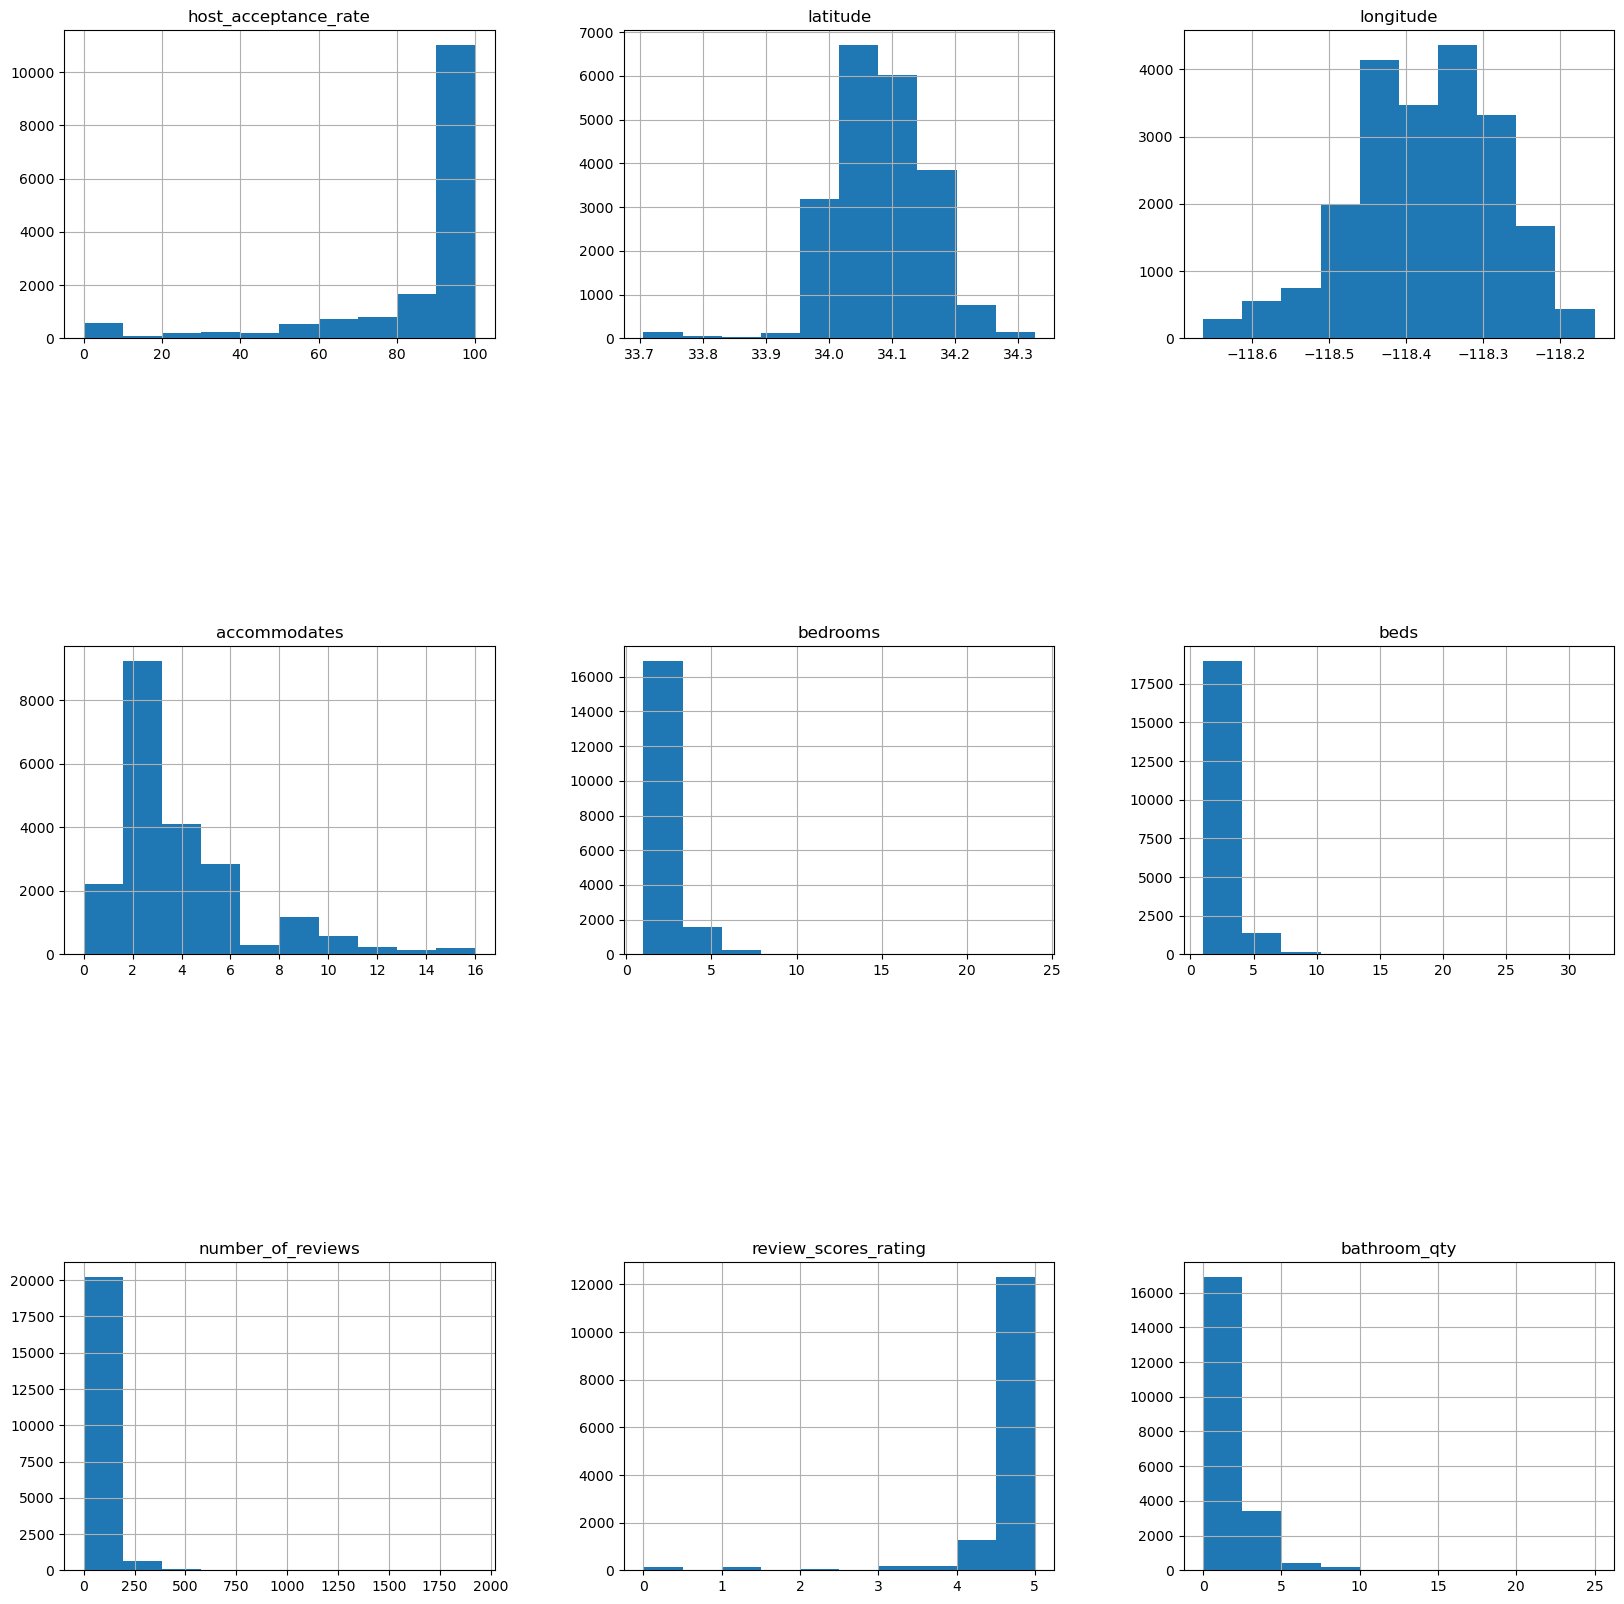

In [12]:
listings.hist(figsize=(20,20))
plt.subplots_adjust(hspace=1);

Observations:
1. Price has long tail and zero values. The high price could be true if the listing is a big house in an expensive neighbourhood. Zero price is not correct and need to be removed.
2. Bedrooms and beds have long tail but this could be true if the listing is an entire big house



#### Price


C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


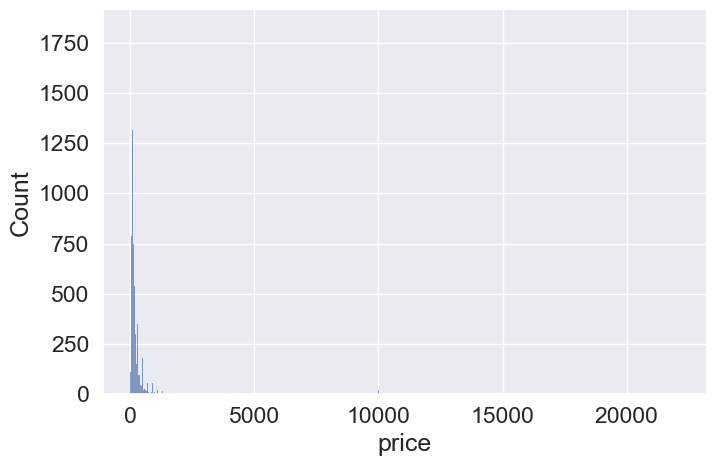

In [13]:
# using str replace function to remove special character and convert them to float
listings.price=listings.price.str.replace("$","").str.replace(",","").astype("float")

#print(listings.price.describe())
sns.set_theme(font_scale=1.5, style="darkgrid")
sns.displot(data=listings, x="price", kind="hist", aspect=1.5)

The price is skewed with couple significantly high price. Is it possible to have price more than 10,000 a night? Let's reveiw the room_type and neighbourhoud of these listings.



In [14]:
# find the listing with price >10000. are they special listings?
listings[listings.price>10000][["price","room_type","accommodates","bathrooms_text","beds","neighborhood","room_type"]]

price        room_type  accommodates bathrooms_text  beds  \
7912   21053.0  Entire home/apt            16     12.5 baths  10.0   
13692  15000.0  Entire home/apt            16       13 baths  11.0   
27063  20084.0  Entire home/apt            16       20 baths  10.0   
27066  16078.0  Entire home/apt            14        9 baths   7.0   
33638  22092.0  Entire home/apt            16      9.5 baths  11.0   

               neighborhood        room_type  
7912                Bel-Air  Entire home/apt  
13692               Bel-Air  Entire home/apt  
27063               Bel-Air  Entire home/apt  
27066  Hollywood Hills West  Entire home/apt  
33638  Hollywood Hills West  Entire home/apt

In [15]:
# find the listings with price= 0
#listings[listings.price==0][["price","room_type","accommodates","bathrooms_text","beds","neighbourhood_cleansed","room_type"]]
listings[listings.price==0].count()

# drop listing with price=0
listings=listings[listings.price!=0]

# drop listings with price>5000
listings=listings[listings.price<5000]

Observations:

Listings > $10,000 are in Bel-Air and near Hollywood which are the residential neighborhood of movie stars who live in Hollywood. The houses here are mansions in the foothill of Santa Monica Mountains. The real estate here is very expensive. The listing shows the room_type is entire home with more than 10 bed rooms and 10 bathrooms and accommodate more than 15 guests. These listings are the perfect for a big group to celebrate special occasion. The price seems right for the area but will drop them.

There are more than 10 listings with price equal to $0 which should be removed.

#### Price with Log Scale


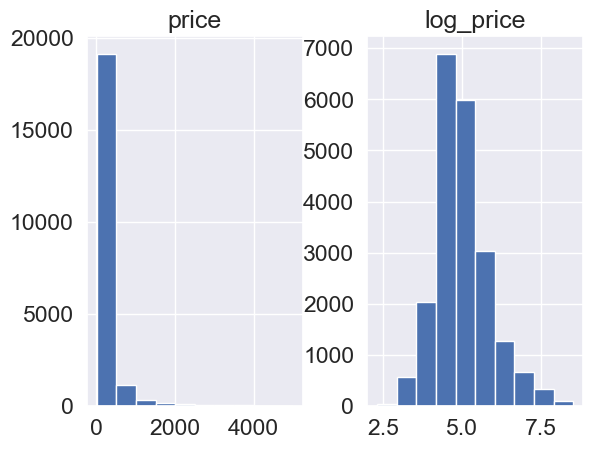

In [16]:
# create a colum for log_price
listings.loc[:,"log_price"]=np.log(listings.loc[:,"price"])
listings[['price','log_price']].hist()

plt.show()

Since the price distribution is not normally distributed, viewing the price in log scale is more visible and interpretablePrice 

## Load Calendar Data Set

In [17]:
calendar = pd.read_csv('calendar.csv.gz', compression='gzip',error_bad_lines=False,nrows=50000)
calendar.head(2)

C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


listing_id        date available    price adjusted_price  minimum_nights  \
0         109  2022-12-07         f  $115.00        $115.00              30   
1         109  2022-12-08         f  $115.00        $115.00              30   

   maximum_nights  
0             730  
1             730

In [18]:
# Random select 300,000 listings to expedite the execution
#calendar_df=calendar.sample(n=5000,replace=True)
#calendar_df=calendar

# convert data type of 'date' from object to datetime
calendar['date']=pd.to_datetime(calendar['date'])

# replace '$' and ',' with '' in column 'price'
calendar.price=calendar.price.apply(lambda x: str(x).replace("$","").replace(",",""))

# drop rows with price= 'nan' and convert price from string to numeric
calendar=calendar[calendar.price!='nan']
calendar.price=pd.to_numeric(calendar.price)

# to be consistent with listings data, we will drop listings with price>5000
calendar=calendar[calendar.price<5000]
calendar_df=calendar


# transform date column to year, month, and day of week columns  
calendar_df['year']=pd.DatetimeIndex(calendar_df.date).year
calendar_df['month']=calendar_df['date'].dt.strftime('%b')
calendar_df['dayofweek']=calendar_df['date'].dt.day_name()
calendar_df.head(2)


listing_id       date available  price adjusted_price  minimum_nights  \
0         109 2022-12-07         f  115.0        $115.00              30   
1         109 2022-12-08         f  115.0        $115.00              30   

   maximum_nights  year month  dayofweek  
0             730  2022   Dec  Wednesday  
1             730  2022   Dec   Thursday

### Data Wrangling Summary

The original listng data shape was 21003x75. By the end of data wrangling, the data shape is 20993x34. 
41 columns were removed due to no data or un-useful data. The main purpose is to keep the important features at a manageable size that may have a good correlation to the price and location 

Removed special characters in host_response_rate, host_acceptance_rate, price columns and convert them from object to float. Split bathroom_text column into bathoom_qty and bathroom_type columns in the hope to find the correlation between the bathroom_qty with the price. There were couple of listings that did not have the numeric bathroom count so they were replaced with the correct numeric quantity. Also removed listings with price equals to zero or more than $5,000 per ngiht.

For calendar dataset, I converted price column to numeric and split date column into month and day of the week to find the correlation between price and market demand in EDA section

#  2. Exploratory Data Analysis


####  Los Angeles Airbnb Map
Location, location, and location is the key factor in derterming the price for a property so to help me better understand the general geography of Los Angeles, I will start the EDA section by putting all listings on a map to do a little research on the demand.  



In [19]:
import plotly.express as px

color_scale=[(0,'blue'),(0.5,'yellow'),(1,'red')]
fig=px.scatter_mapbox(listings,
                     lat="latitude",
                     lon="longitude",
                     color='price',
                     color_continuous_scale=color_scale,
                     size="price",
                     zoom=10,
                     height=800,
                     width=1000)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Using scatter_map along with features latitude, longiture, and price, I was able to view all Airbnb listings in one beautiful colorful map. Knowing the hilly and flat terrain of the city, I am not surpriced to see most of listings are on the flat area.

The colors blue, yellow, to red is the price range from low to high. You can see there are listing prices as high as five thousands dollar a day. That is insane! These listings mostly reside be on the hill side with fantastic canyon view of the city.




#### Top Listings By City

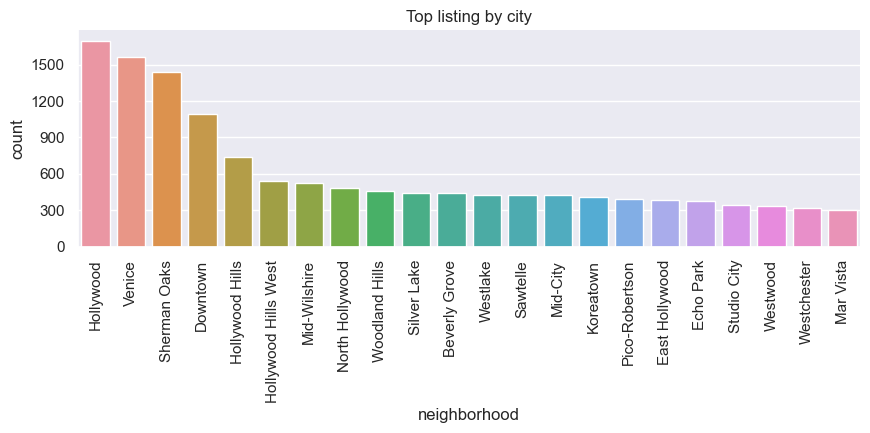

In [20]:
count_ranks=listings.groupby('neighborhood')['price'].agg(['count']).sort_values("count",ascending=True).query('count >300')[::-1]
count_ranks
count_ranks.reset_index(inplace=True)
count_ranks.columns
#sns.set_palette("RdBu")
sns.set(font_scale=1)
sns.catplot(x='neighborhood',y='count',data=count_ranks, kind='bar',aspect=6/2,height=3)
plt.xticks(rotation=90)
plt.yticks(np.linspace(0,1500,6))
plt.title("Top listing by city")
plt.show()


It is a challenge to choose where to stay in Los Angeles since it is one of the largest and most dynamic cities in the US and the main tourist attractions are scattered everywhere. Moreover, the public transportation is not convenient here as it is in New York or San Francisco so almost everyone live in here use car for transportation. Let's dive in to the top three cities and find out why they are popular with Airbnb.

1. Hollywood is the best area to stay in Los Angeles due to it location and security. It is the headquarters of the most famous film studio in the world, Universal Studios and the walk of Fame. Food are also good here

2. Venice is one of the  most popular white sand beaches in Southern California with many thing to do and see like street performers, colorful street art, trendy bars and restaurants. 

3. Sherman Oaks is more affordable, bigger property and not too far from main attractions

#### Average Price by City

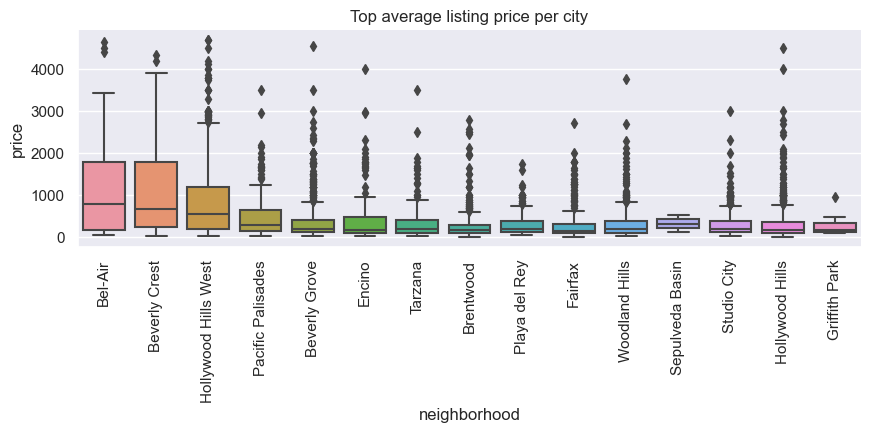

In [21]:
ranks=listings.groupby('neighborhood')['price'].agg(['mean']).sort_values("mean",ascending=True).query('mean >300')[::-1]
#sns.set_palette("RdBu")
sns.set(font_scale=1)
sns.catplot(x='neighborhood',y='price',data=listings,kind='box',order=ranks.index,aspect=6/2,height=3)
plt.xticks(rotation=90)
plt.title('Top average listing price per city')
plt.show()

Bel-Air. Beverly Crest, and Hollywood Hills West are the most prestigious upscale neighborhoods on the Western part of Los Angeles with very high standard of living. Who can afford renting a property in these area? 

#### Room Type

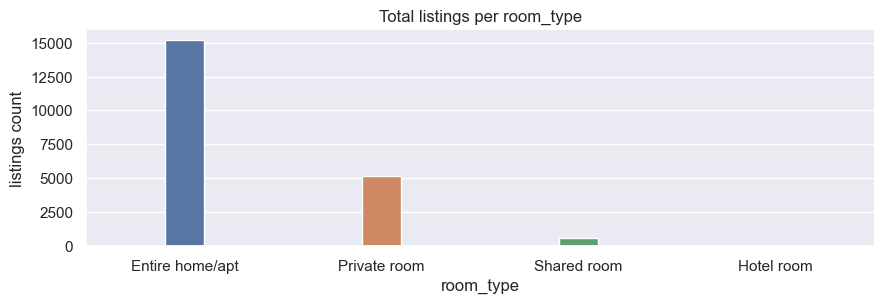

In [22]:
room_ranks=listings.room_type.value_counts().reset_index()
room_ranks.columns=['room_type',"counts"]
#sns.set_palette("RdBu")
sns.set(font_scale=1)
sns.catplot(x='room_type',y='counts',data=room_ranks, kind='bar',aspect=6/2,width=0.2,height=3)
plt.title("Total listings per room_type")
plt.ylabel("listings count")
plt.show()

In [23]:
listings=listings[listings['room_type']!="Hotel room"]
listings.room_type.nunique()

3

Entire home/apt is the dominant room type which represents 70% of all types of rooms. This is the room type of my property so i should pay more attention during modeling. 

Private room is the second most popular room type. In many expensive and high demand cities such as New York and San Francisco, the research shows it may be possible to pay the entire rent on a two bedroom apartment by filling one of the rooms for 21 days a month. Basically it is rent free for the hosts but keep in mind lots time commitment is involved. 

I am surprised to see the hotel as one of the room types, even though there are not many listings but shows how popular Airbnb is that hotels use it as an additional platform of advertising. Will drop all hotel listing

A side note for first-time homeowners out there, more Airbnb listings mean higher rent and are bad for the housing market. 
 

### Number of guests

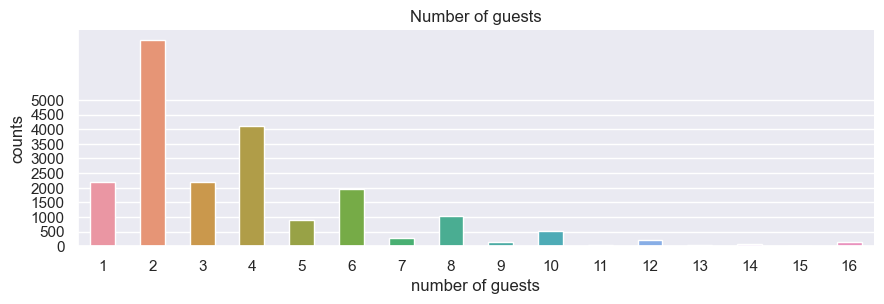

In [24]:
guests_ranks=listings.accommodates.value_counts().reset_index()
guests_ranks.columns=['number of guests','counts']
#sns.set_palette("RdBu")
sns.set(font_scale=1)
sns.catplot(x='number of guests',y='counts',data=guests_ranks, kind='bar',aspect=6/2,width=0.5,height=3)
plt.title("Number of guests")
plt.yticks(np.linspace(0,5000,11))
plt.show()

The most popular number of guests per listing is two or four. My property also has two bedrooms. There are listings for more than ten guests which is be good for big group. 

### Price vs. month

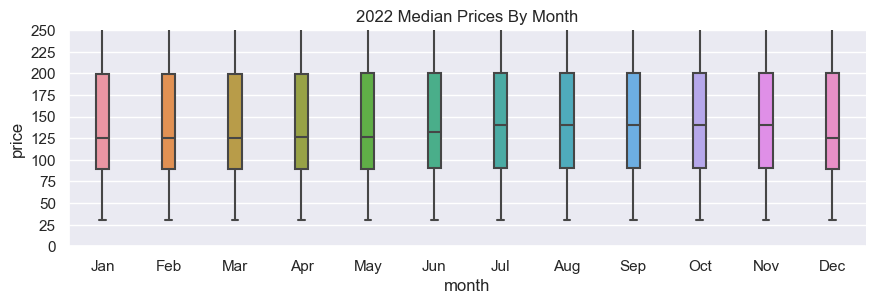

In [25]:
#fig, ax = pyplot.subplots(figsize=(10,5)
months_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
#sns.set_palette("RdBu")
sns.set(font_scale=1)
sns.catplot(x='month',y='price',data=calendar_df,kind='box',order=months_order,aspect=6/2,height=3,width=0.2)
plt.ylim(0,250)
plt.yticks(np.linspace(0,250,11))
plt.title('2022 Median Prices By Month')
plt.show()

As shown in the plot, it is not a good idea to apply the exact same rate for 365 days a year. Similar to Airbnb, all companies in the travel industry set their prices based on seasonal market demand. Prices are usually soft during school months then peak in the summer months and the holiday season. So it is good to set higher rates for the high season to maximize profit and lower prices for the low season to maximize occupancy. 

Los Angeles is a sunshine city. It has two seasons, dry summer and very mild winter. As a result, there are not many winter activities to do here and I am wondering if that is why the price dipped in December and Janury. 

In contrast with the host, now I know when to travel to save money on hotels. 

### Price vs. day of week

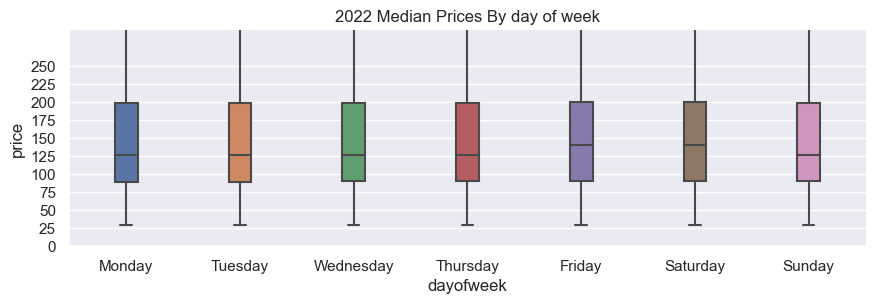

In [26]:
#fig, ax = pyplot.subplots(figsize=(10,5)
day_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
#sns.set_palette("RdBu")
sns.catplot(x='dayofweek',y='price',data=calendar_df,kind='box',order=day_order,aspect=6/2,height=3,width=0.2)
plt.ylim(0,300)
plt.yticks(np.linspace(0,250,11))
plt.title('2022 Median Prices By day of week')
plt.show()

I did the same analysis for the average prices by day of week. The price for Friday and Saturday should be higher. It is understandable as more acitivites happened on these days.  

#### Numeric Feature Heatmap

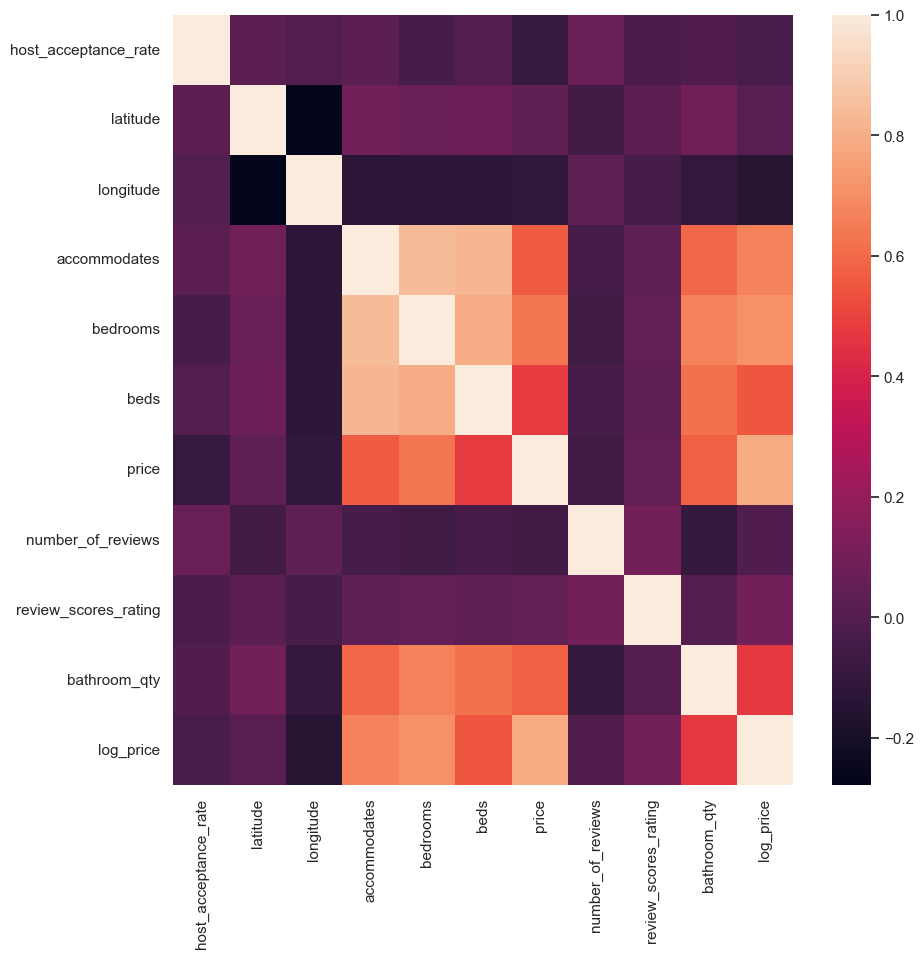

In [27]:
# show  a seaborn heatmap of correlation in airbnb data
plt.subplots(figsize=(10,10))
sns.heatmap(listings.corr());
plt.show()

There is a lot to take from the heatmap. First, as expected accommodates show a strong positive correlation with bedrooms and beds as more people require more rooms and beds. It looks like most of the listings with availability for 30 days are also available for 60 and 90 days but not so much for 365 days. Regarding review scores, do they matter to the guests? Yes, of course! They are the features that guests would look at first when they shop on Airbnb, especially the location and cleanliness. However, the reviews absolutely have no correlation to the price. 

So what features are important to the pricing strategy? Let’s turn our attention back to accommodates, bedrooms, beds, and bathroom_qty. These are the only four features that show resonable positive correlation to the price.  Let’s look at the scatter plots.

#### Price vs. all numeric features 

In [28]:
#define a function to create scatterplotf of price against numeric feature

def scatterplots ( columns, ncol=None, figsize=(10,1)):
    if ncol is None:
        ncol=len(columns)
    nrow=int(np.ceil(len(columns)/ncol))
    fig,axes=plt.subplots(nrow,ncol,figsize=figsize,squeeze=False)
    fig.subplots_adjust(wspace=0.5,hspace=0.6)
    for i,col in enumerate(columns):
        ax=axes.flatten()[i]
        ax.scatter(x=col,y='price',data=listings,alpha=0.5)
        ax.set(xlabel=col, ylabel='price')
    nsubplots=nrow*ncol
    for empty in range(i*1,nsubplots):
        axes.flatten()[empty].set_visible(False)


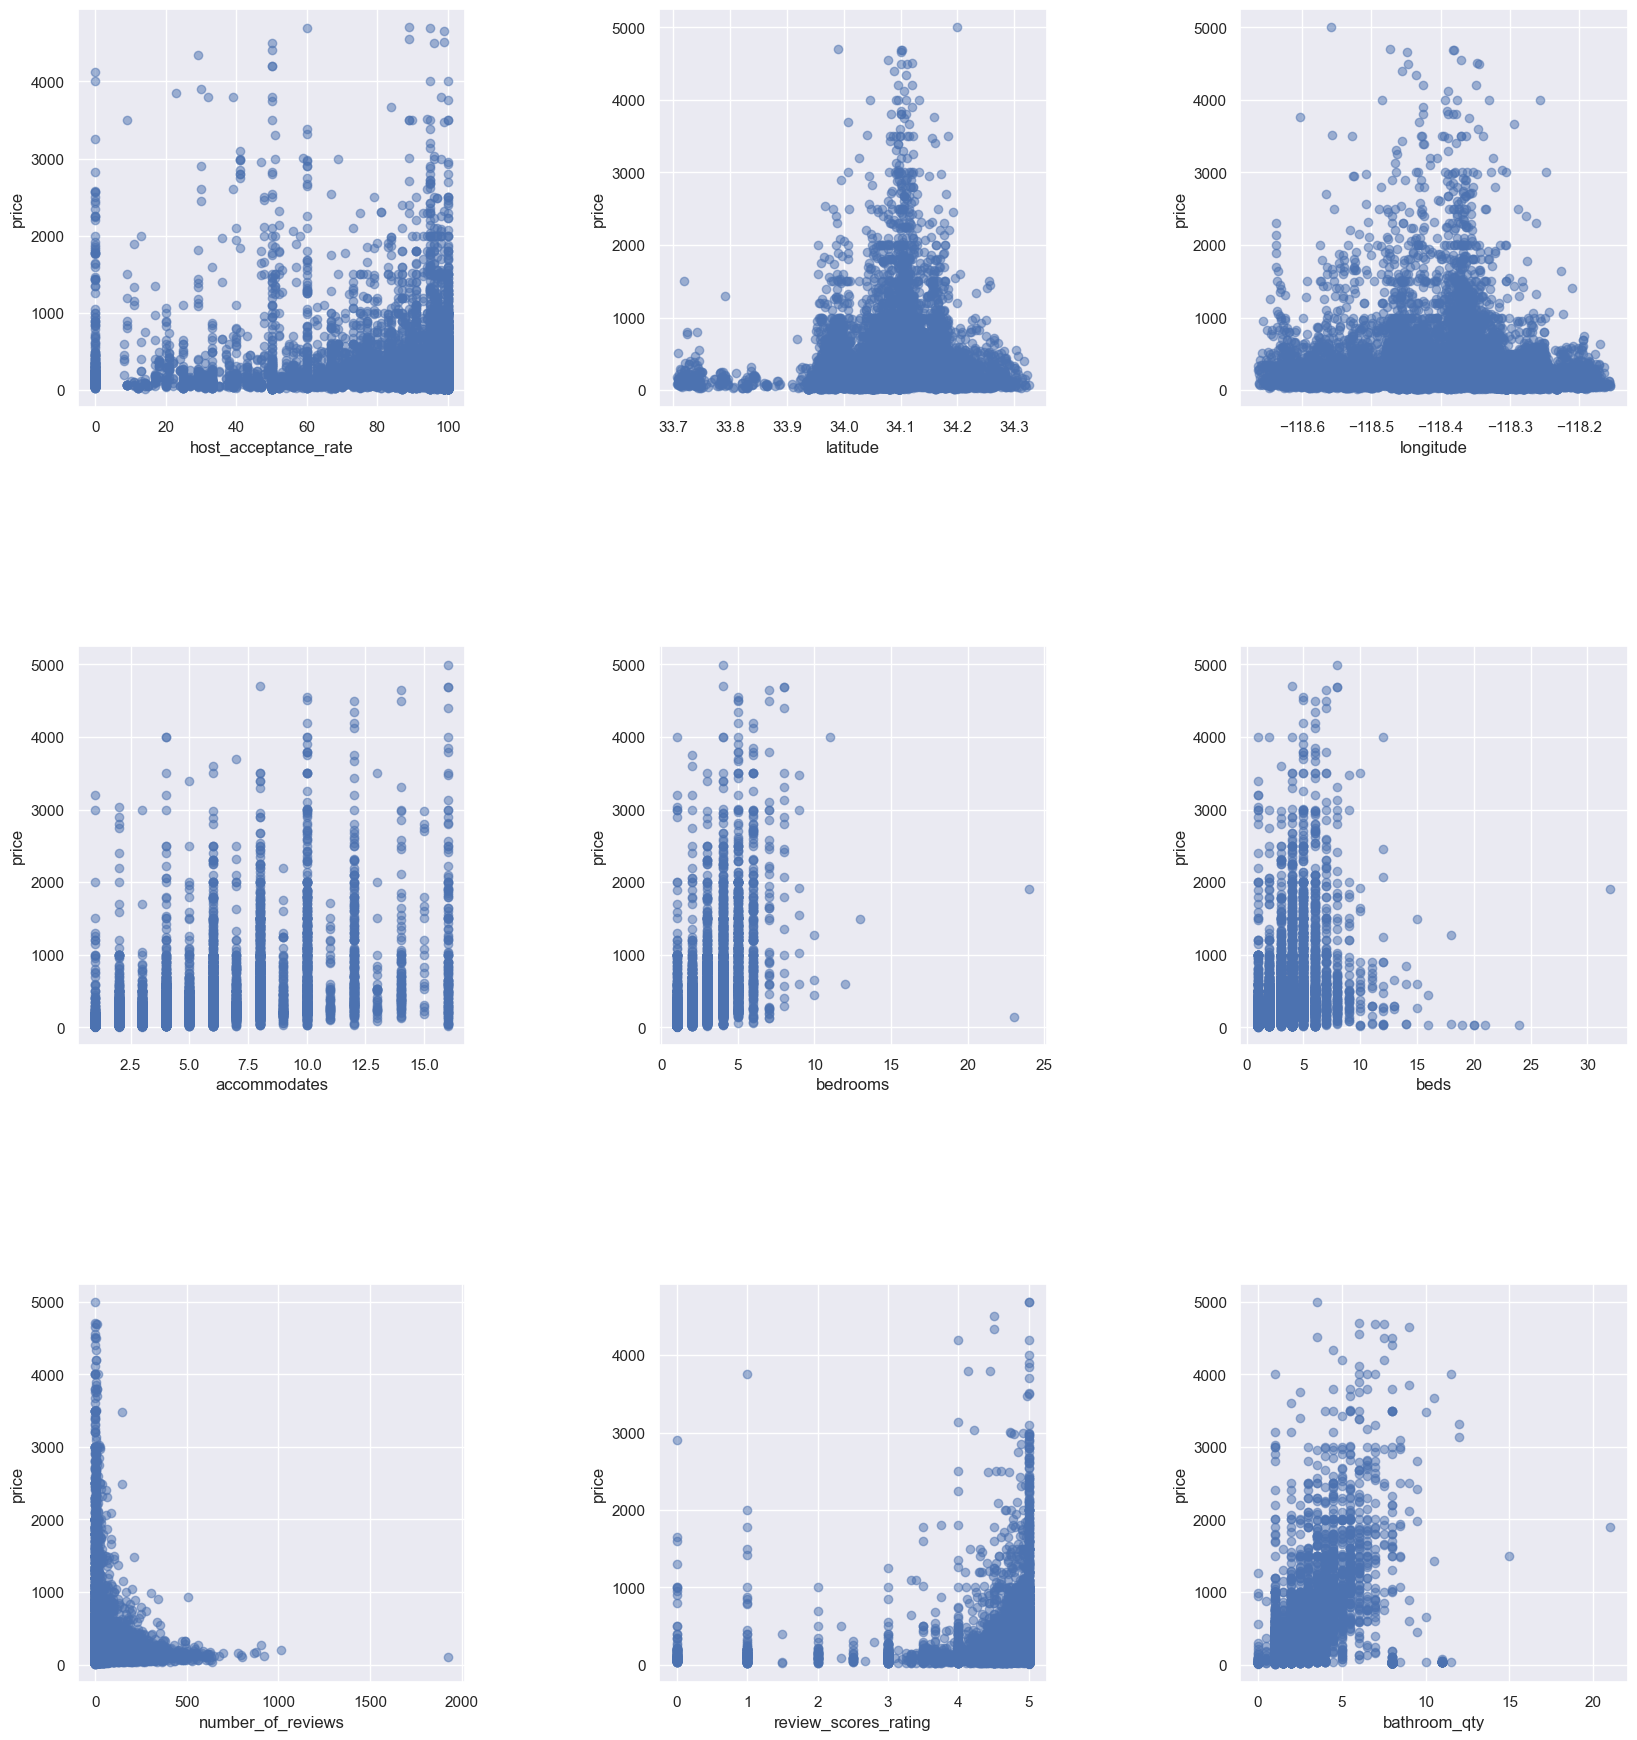

In [29]:
# select numeric features for scatterplots and call scatterplots
features= listings.select_dtypes(include=np.number).columns.tolist()
features.remove("price")
scatterplots(features,ncol=3,figsize=(20,30))

The scatter plots confirm the possitive correlation we saw with the heatmap which are bedrooms, beds and bathroom_qty but not so much on accommodates

### EDA Summary


The best way to understand the data is to demonstrate the data visually. 

It seems intuitively correct that there are patterns suggested of relationships between price and bedrooms, beds, bathroom_qty and accommodates which in fact have a relationship between themself as bigger houses offer more rooms and accommodate. 


Location is the most important factor when searching for a place on Airbnb. Even though latitude and longitude do not show a correlation with price, I am curious to see if they make difference.   

To be a good host is to be flexible with price. Remember that the prices are soft during school months and then increase in the summer months and holiday seasons. Friday and Saturday also have a higher price. Thus, it is ok to set higher rates for the high season to maximize profit and lower prices for the low season to maximize occupancy.

Moving on to the modeling phase, I would like to use the following features:


* Independent variables: 
    * latitude
    * longitude
    * neighbourhood
    * review_scores_rating
    * room_type
    * accommodates
    * bedrooms
    * beds
    * bathroom_qty
    * number_of_reviews

* Dependent variable: price






# 3. Pre-Processing and Training Data
Recall during data wrangling, we have left many missing values untouched as we wanted to view the distrubiton from all listings. Now, with a good understanding of the data and their relationship. Let’s transform the raw data into meaningful columns to prepare for modeling with the following the steps below

1. Replace NaN values
2. Create dummy features for categorical variables
3. Standardize the magnitude of numeric features using a scaler
4. Split data into training and testing datasets

In [30]:
print(listings.isnull().sum())
print(listings.shape)

host_acceptance_rate    5031
neighborhood               0
latitude                   0
longitude                  0
room_type                  0
accommodates               0
bathrooms_text            10
bedrooms                2229
beds                     440
amenities                  0
price                      0
number_of_reviews          0
review_scores_rating    6659
bathroom_qty              10
bathroom_type             22
log_price                  0
dtype: int64
(20908, 16)


#### bedrooms, beds, reviews, scores_rating, price data

In [32]:
# Remove rows with missing data for bedrooms and beds as they are two important features for pricing
listings.dropna(subset=['bedrooms','beds'],how='any',inplace=True)

# Remvoe prices > $400 as 99% of listings are <$400, don't want high price to skew the data
listings=listings[listings.price<400]

# select listings with reviews and scores_rating>0--> these are important features that we use when shopping for a rental
listings=listings[listings.number_of_reviews>0]
listings=listings[listings.review_scores_rating>0]

# indenpendent variables
X=listings[['latitude','longitude','neighborhood','review_scores_rating','room_type', 'accommodates', 
            'bedrooms', 'beds', 'bathroom_qty','number_of_reviews']]
# dependent varible
y=listings['price']

print(X.shape)
print(y.shape)

(10634, 10)
(10634,)


#### Deal with bathroom_qty missing data

In [33]:
# view the listings with missing data to find the correct value for replacement 
(X[X.bathroom_qty.isnull()])


latitude  longitude     neighborhood  review_scores_rating  \
27   34.12801 -118.31919  Hollywood Hills                  4.90   
319  34.06645 -118.35210     Mid-Wilshire                  4.93   
385  34.08974 -118.27021      Silver Lake                  4.94   

           room_type  accommodates  bedrooms  beds  bathroom_qty  \
27   Entire home/apt             2       1.0   1.0           NaN   
319     Private room             2       1.0   1.0           NaN   
385  Entire home/apt             2       1.0   1.0           NaN   

     number_of_reviews  
27                 484  
319                 32  
385                159

In [34]:
# imputing bathroom_qty with 1 as these are entire home with 1 bedroom and 1 bed
X['bathroom_qty'].fillna(1,inplace=True)

C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Get Dummies Variables and split data into train and test sets

In [59]:
# get dummies
X=pd.get_dummies(X)

# split data into train and test datasets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

print(X_train.shape)
print(X_test.shape)

(7975, 124)
(2659, 124)


#### Imputing

In [36]:
# fillna with median
X_defaults_median = X_train.median()
X_tr=X_train.fillna(value=X_defaults_median)
X_ts=X_test.fillna(value=X_defaults_median)

#### Scaling

In [58]:
# use standard scaler
scaler=StandardScaler()
scaler.fit(X_tr)
X_tr=scaler.transform(X_tr)  
X_ts=scaler.transform(X_ts)
print(X_train.shape)
print(X_test.shape)

(7975, 124)
(2659, 124)


After transforming, the train/test datasets are expanded from 9 columns to 124 columns and ready for modeling.